<a href="https://colab.research.google.com/github/sysadminamit/HelpfulnessPrediction-of-Online-Review/blob/master/Glove50CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls

adc.json  gdrive  sample_data  saved_models


In [0]:
import pandas as pd
df=pd.read_csv('gdrive/My Drive/AmazonElectronicsProductReviewClean.csv')

In [0]:
df = df.dropna()

In [0]:
df = df.sample(n = 100000)
#df.head(1)

In [6]:
df['Helpfulfactor'].value_counts()

1.0    67181
0.0    32819
Name: Helpfulfactor, dtype: int64

In [7]:
from sklearn.utils import resample
data_majority = df[df.Helpfulfactor == 1.0 ]
data_minority = df[df.Helpfulfactor == 0.0 ]
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=67040,    # to match majority class
                                 random_state=123) # reproducible results
df = pd.concat([data_majority, data_minority_upsampled])
df['Helpfulfactor'].value_counts()

1.0    67181
0.0    67040
Name: Helpfulfactor, dtype: int64

In [8]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, BatchNormalization, Embedding, GlobalMaxPooling1D
import keras
from keras.layers import *
from keras.layers import concatenate, CuDNNGRU
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model


import nltk
nltk.download('stopwords')
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 512  # Size of the validation set
NB_START_EPOCHS = 25  # Number of epochs we usually start to train with
BATCH_SIZE = 128  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 100 # Maximum number of words in a sequence
GLOVE_DIM = 50  # Number of dimensions of the GloVe word embeddings

In [0]:
#df = df.reindex(np.random.permutation(df.index))  
df = df[['review', 'Helpfulfactor']]
#df.review = df.review.apply(remove_stopwords).apply(remove_mentions)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.review, df.Helpfulfactor, test_size=0.02, random_state=42)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 131536
# Test data samples: 2685


In [0]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [13]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    131536.00000
mean          7.90449
std           5.88133
min           1.00000
25%           4.00000
50%           7.00000
75%          10.00000
max         208.00000
Name: review, dtype: float64

In [0]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [0]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [16]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=42)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (13154, 100)


In [0]:
!cp "/content/gdrive/My Drive/glove.6B.50d.txt" "glove.6B.50d.txt"

In [18]:
embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [0]:
nb_words = min(NB_WORDS, len(tk.word_index))
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = embeddings_index.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [0]:
seed = 7

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding,AveragePooling1D
from keras.optimizers import Adam
import keras
from matplotlib import pyplot as plt

In [0]:
model_cnn_02 = Sequential()
e = Embedding(10000, 50, weights=[emb_matrix], input_length=100, trainable=False)
model_cnn_02.add(e)

model_cnn_02.add(Conv1D(filters=300, kernel_size=3, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())

model_cnn_02.add(Dropout(0.4))

model_cnn_02.add(Dense(96, activation='relu'))


model_cnn_02.add(Dense(2, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history = model_cnn_02.fit(X_train_emb, y_train_emb, validation_data=(X_valid_emb, y_valid_emb), epochs=500, batch_size=128, verbose=1)

Train on 118258 samples, validate on 13140 samples
Epoch 1/500
118258/118258 [==============================] - 10s 81us/step - loss: 0.6995 - acc: 0.5037 - val_loss: 0.6930 - val_acc: 0.5114
Epoch 2/500
118258/118258 [==============================] - 9s 76us/step - loss: 0.6940 - acc: 0.5115 - val_loss: 0.6923 - val_acc: 0.5171
Epoch 3/500
118258/118258 [==============================] - 9s 77us/step - loss: 0.6919 - acc: 0.5213 - val_loss: 0.6916 - val_acc: 0.5218
Epoch 4/500
118258/118258 [==============================] - 9s 77us/step - loss: 0.6905 - acc: 0.5270 - val_loss: 0.6910 - val_acc: 0.5239
Epoch 5/500
118258/118258 [==============================] - 9s 77us/step - loss: 0.6892 - acc: 0.5346 - val_loss: 0.6897 - val_acc: 0.5343
Epoch 6/500
118258/118258 [==============================] - 9s 76us/step - loss: 0.6872 - acc: 0.5432 - val_loss: 0.6882 - val_acc: 0.5396
Epoch 7/500
118258/118258 [==============================] - 9s 76us/step - loss: 0.6851 - acc: 0.5502 - val

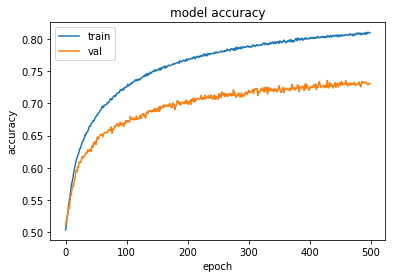

In [0]:
#history = model_cnn_02.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

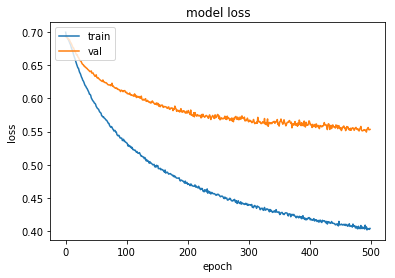

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [0]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'TrigramModel500Epoch.hdf5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_cnn_02.save(model_path)

print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/TrigramModel500Epoch.hdf5 


In [0]:
from keras.models import load_model

model = load_model(model_path)
model.evaluate(x=X_valid_emb, y=y_valid_emb)

13140/13140 [==============================] - 1s 96us/step


[0.5532575474754317, 0.7305936073240805]

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'TrigramModel500Epoch.hdf5',
  'mimeType': 'text/plain'
}
media = MediaFileUpload('/content/saved_models/TrigramModel500Epoch.hdf5', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1fr-wIOpg1EgtnXotBHSw5QyK45BWmeJI


In [0]:
yhat_cnn = model.predict(X_test_seq_trunc)

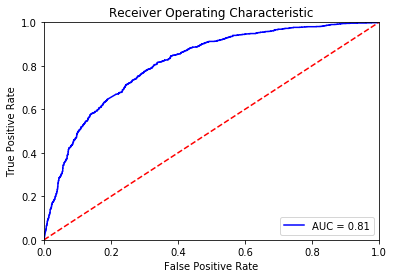

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test_seq_trunc)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Four gram Model In Keras 


In [0]:
#Fourgram Moddl In keras
model_cnn_04 = Sequential()
e = Embedding(10000, 50, weights=[emb_matrix], input_length=100, trainable=False)
model_cnn_04.add(e)

model_cnn_04.add(Conv1D(filters=300, kernel_size=4, padding='valid', activation='relu', strides=1))
model_cnn_04.add(GlobalMaxPooling1D())

model_cnn_04.add(Dropout(0.4))

model_cnn_04.add(Dense(96, activation='relu'))


model_cnn_04.add(Dense(2, activation='sigmoid'))
model_cnn_04.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history_04 = model_cnn_04.fit(X_train_emb, y_train_emb, validation_data=(X_valid_emb, y_valid_emb), epochs=500, batch_size=128, verbose=1)

Train on 118361 samples, validate on 13152 samples
Epoch 1/500
118361/118361 [==============================] - 10s 88us/step - loss: 0.6992 - acc: 0.5037 - val_loss: 0.6926 - val_acc: 0.5106
Epoch 2/500
118361/118361 [==============================] - 10s 84us/step - loss: 0.6930 - acc: 0.5132 - val_loss: 0.6918 - val_acc: 0.5215
Epoch 3/500
118361/118361 [==============================] - 10s 84us/step - loss: 0.6912 - acc: 0.5239 - val_loss: 0.6914 - val_acc: 0.5240
Epoch 4/500
118361/118361 [==============================] - 10s 84us/step - loss: 0.6898 - acc: 0.5303 - val_loss: 0.6901 - val_acc: 0.5281
Epoch 5/500
118361/118361 [==============================] - 10s 83us/step - loss: 0.6874 - acc: 0.5398 - val_loss: 0.6880 - val_acc: 0.5365
Epoch 6/500
118361/118361 [==============================] - 10s 84us/step - loss: 0.6840 - acc: 0.5520 - val_loss: 0.6857 - val_acc: 0.5434
Epoch 7/500
118361/118361 [==============================] - 10s 84us/step - loss: 0.6811 - acc: 0.5596

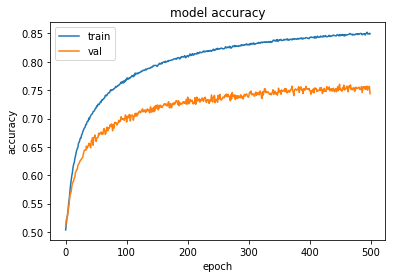

In [0]:
plt.plot(history_04.history['acc'])
plt.plot(history_04.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

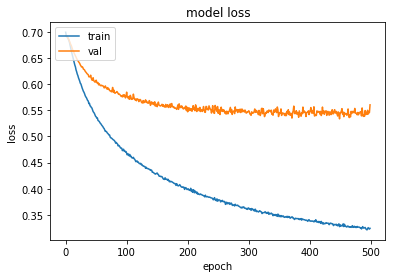

In [0]:
plt.plot(history_04.history['loss'])
plt.plot(history_04.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'FourgramModel500Epoch.hdf5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_cnn_04.save(model_path)

print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/FourgramModel500Epoch.hdf5 


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'FourgramModel500Epoch.hdf5',
  'mimeType': 'text/plain'
}
media = MediaFileUpload('/content/saved_models/FourgramModel500Epoch.hdf5', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1HmPRT9xsRJ6Ou87oXSlKuKgFIkapLvyI


In [0]:
from keras.models import load_model

model = load_model(model_path)
model.evaluate(x=X_valid_emb, y=y_valid_emb)

13152/13152 [==============================] - 1s 96us/step


[0.5604613756176329, 0.7436511557177615]

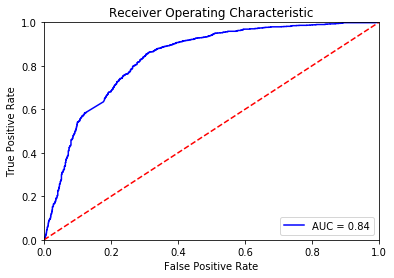

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test_seq_trunc)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Fivegram Model


In [21]:
#Fourgram Moddl In keras
model_cnn_05 = Sequential()
e = Embedding(10000, 50, weights=[emb_matrix], input_length=100, trainable=False)
model_cnn_05.add(e)

model_cnn_05.add(Conv1D(filters=300, kernel_size=5, padding='valid', activation='relu', strides=1))
model_cnn_05.add(GlobalMaxPooling1D())

model_cnn_05.add(Dropout(0.4))

model_cnn_05.add(Dense(96, activation='relu'))


model_cnn_05.add(Dense(2, activation='sigmoid'))
model_cnn_05.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history_05 = model_cnn_05.fit(X_train_emb, y_train_emb, validation_data=(X_valid_emb, y_valid_emb), epochs=300, batch_size=128, verbose=1)

W0724 09:04:31.746909 140033040213888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 09:04:31.776178 140033040213888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 09:04:31.779553 140033040213888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 09:04:31.789271 140033040213888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0724 09:04:31.790302 1400330402

Train on 118382 samples, validate on 13154 samples
Epoch 1/300
118382/118382 [==============================] - 8s 64us/step - loss: 0.6983 - acc: 0.5055 - val_loss: 0.6923 - val_acc: 0.5160
Epoch 2/300
118382/118382 [==============================] - 5s 42us/step - loss: 0.6929 - acc: 0.5164 - val_loss: 0.6913 - val_acc: 0.5208
Epoch 3/300
118382/118382 [==============================] - 5s 43us/step - loss: 0.6907 - acc: 0.5273 - val_loss: 0.6897 - val_acc: 0.5314
Epoch 4/300
118382/118382 [==============================] - 5s 43us/step - loss: 0.6880 - acc: 0.5392 - val_loss: 0.6878 - val_acc: 0.5379
Epoch 5/300
118382/118382 [==============================] - 5s 43us/step - loss: 0.6843 - acc: 0.5520 - val_loss: 0.6839 - val_acc: 0.5560
Epoch 6/300
118382/118382 [==============================] - 5s 43us/step - loss: 0.6791 - acc: 0.5670 - val_loss: 0.6808 - val_acc: 0.5609
Epoch 7/300
118382/118382 [==============================] - 5s 42us/step - loss: 0.6729 - acc: 0.5779 - val_

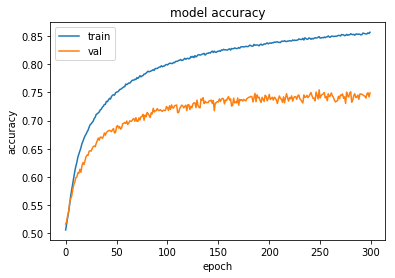

In [22]:
plt.plot(history_05.history['acc'])
plt.plot(history_05.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

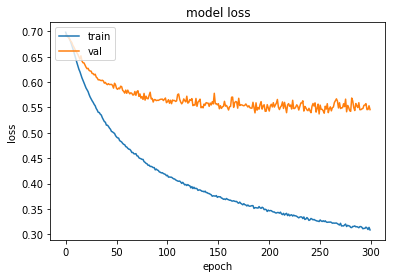

In [23]:
plt.plot(history_05.history['loss'])
plt.plot(history_05.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
!ls

adc.json  gdrive  glove.6B.50d.txt  sample_data  saved_models


In [38]:
cd ..

/content


In [39]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'FivegramModel300Epoch.hdf5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path_05 = os.path.join(save_dir, model_name)
model_cnn_05.save(model_path_05)

print('Saved trained model at %s ' % model_path_05)

Saved trained model at /content/saved_model/FivegramModel300Epoch.hdf5 


In [0]:
from google.colab import auth
auth.authenticate_user()

In [41]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

W0724 09:47:33.684933 140033040213888 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [43]:
from googleapiclient.http import MediaFileUpload

file_metadata = {
  'name': 'FivegramModel300Epoch.hdf5',
  'mimeType': 'text/plain'
}
media = MediaFileUpload('/content/saved_model/FivegramModel300Epoch.hdf5', 
                        mimetype='text/plain',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1wTz9Ry1GKDVmWkkuhJ7DCv78Q_EoD3qv


In [45]:
from keras.models import load_model

model = load_model(model_path_05)
model_cnn_05.evaluate(x=X_valid_emb, y=y_valid_emb)

13154/13154 [==============================] - 1s 62us/step


[0.5458062305328276, 0.7491257412194009]

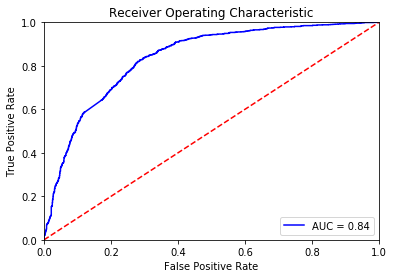

In [46]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model_cnn_05.predict_proba(X_test_seq_trunc)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()